In [ ]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [2]:
!pip install pickle5

In [3]:
!cp "/content/drive/My Drive/Colab Notebooks/AMPsNonAMPs_df.plk" .

In [ ]:
!pip install scikit-plot

In [4]:
import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve,auc
from keras.wrappers.scikit_learn import KerasClassifier

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, GlobalMaxPooling1D
from tensorflow.python.keras.layers.recurrent import LSTM
# CuDNNLSTM error; The error was because from TensorFlow 2 you do not need to specify CuDNNLSTM. 
# You can just use LSTM with no activation function and it will automatically use the CuDNN version. You do have to install CuDNN first.

from keras.callbacks import ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [5]:
import pickle5 as pickle
with open( "AMPsNonAMPs_df.plk", 'rb') as file:
    AMPs_df = pickle.load(file)

In [ ]:
# AMPs_df = pd.read_pickle('AMPsNonAMPs_df.plk')
AMPs_df = pd.read_pickle('AMPsNonAMPs_df.239.plk')
AMPs_df

### Utility function: plot_history, display_model_score

In [ ]:
def plot_history(history):
  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

# Display model score(Loss & Accuracy) across all sets.
def display_model_score(model, train, val, test):
  train_score = model.evaluate(train[0], train[1], verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)
  val_score = model.evaluate(val[0], val[1], verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  test_score = model.evaluate(test[0], test[1], verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

def plot_history_CV(cv, estimator,x,y):
  # plot arrows
  fig1 = plt.figure(figsize=[12,12])
  ax1 = fig1.add_subplot(111,aspect = 'equal')
  ax1.add_patch(
      patches.Arrow(0.45,0.5,-0.25,0.25,width=0.3,color='green',alpha = 0.5)
      )
  ax1.add_patch(
      patches.Arrow(0.5,0.45,0.25,-0.25,width=0.3,color='red',alpha = 0.5)
      )

  tprs = []
  aucs = []
  mean_fpr = np.linspace(0,1,100)
  i = 1
  for train,test in cv.split(x,y):
      model = create_Modelbaseline()
      model.fit(x[train],y.iloc[train],
            epochs=30,
            shuffle=True,verbose=0)
      prediction = model.predict(x[test])
      fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
      tprs.append(interp(mean_fpr, fpr, tpr))
      roc_auc = auc(fpr, tpr)
      aucs.append(roc_auc)
      plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
      i= i+1

  plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  plt.plot(mean_fpr, mean_tpr, color='blue',
          label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.text(0.32,0.7,'More accurate area',fontsize = 12)
  plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
  plt.show()

# Split Train/ Test / Validation set

In [6]:
X= np.array(AMPs_df['reps'].to_list())
y= np.array(AMPs_df['class'].to_list())

In [7]:
input_shape  = X.shape

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2

In [9]:
# Given data size
print('Train size: ', len(X_train))
print('Val size: ', len(X_val))
print('Test size: ', len(X_test))

Train size:  25467
Val size:  8489
Test size:  8489


# Model 1: OurModel 

## Keras

In [ ]:
def create_Modelbaseline():
  x_input = Input(shape=(1900,))
  layer_0 = Dense(896)(x_input)
  dropout_0 = Dropout(0.5)(layer_0)
  layer_1 = Dense(448)(dropout_0)
  dropout_1 = Dropout(0.5)(layer_1)
  layer_2 = Dense(224)(dropout_1)
  dropout_2 = Dropout(0.5)(layer_2)
  layer_3 = Dense(112)(dropout_2)
  dropout_3 = Dropout(0.5)(layer_3)
  layer_4 = Dense(56)(dropout_3)
  dropout_4 = Dropout(0.5)(layer_4)
  x_output = Dense(1, activation='sigmoid', name='output_layer')(dropout_4)

  model = Model(inputs=x_input, outputs=x_output)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
 model = create_Modelbaseline()
 model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1900)]            0         
_________________________________________________________________
dense_11 (Dense)             (None, 896)               1703296   
_________________________________________________________________
dropout_11 (Dropout)         (None, 896)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 448)               401856    
_________________________________________________________________
dropout_12 (Dropout)         (None, 448)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 224)               100576    
_________________________________________________________________
dropout_13 (Dropout)         (None, 224)              

In [ ]:
checkpoint = ModelCheckpoint("our_best_model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                     callbacks=[checkpoint], verbose=2)


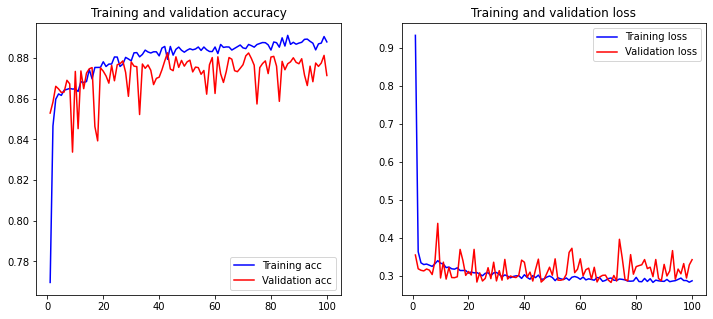

In [ ]:
plot_history(history)

Overfitting if: training loss >> validation loss, training loss much greater than validation loss. That is underfitting.

Underfitting if: training loss << validation loss, training loss much less than validation loss. That is overfitting.

1. The training loss keeps decreasing after every epoch. Our model is learning to recognize the specific sequences in the training set. (Overfitting)
2. The validation loss keeps .....


In [ ]:
display_model_score(model,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

796/796 [==============================] - 1s 2ms/step - loss: 0.2443 - accuracy: 0.9010
Train loss:  0.24427326023578644
Train accuracy:  0.9010484218597412
----------------------------------------------------------------------
266/266 [==============================] - 0s 2ms/step - loss: 0.3437 - accuracy: 0.8715
Val loss:  0.3436543345451355
Val accuracy:  0.8714807629585266
----------------------------------------------------------------------
266/266 [==============================] - 0s 2ms/step - loss: 0.3325 - accuracy: 0.8777
Test loss:  0.33247143030166626
Test accuracy:  0.8777241110801697


In [ ]:
y_probas = model.predict(X_test)
y_probas

array([[1.5158687e-03],
       [3.8974282e-01],
       [9.5025122e-01],
       ...,
       [1.7285377e-01],
       [1.2119177e-06],
       [3.4751445e-01]], dtype=float32)

In [ ]:
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)

print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      4300
           1       0.91      0.83      0.87      4189

    accuracy                           0.88      8489
   macro avg       0.88      0.88      0.88      8489
weighted avg       0.88      0.88      0.88      8489



# Cross validation with whole dataset

In [ ]:

estimator = KerasClassifier(build_fn=create_Modelbaseline, epochs=100,verbose=0)
kfold = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(estimator, X, y, cv=kfold)

In [ ]:
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 88.37% (0.50%)


The below models are from https://towardsdatascience.com/protein-sequence-classification-99c80d0ad2df

# Model 2: Bidirectional LSTM

Embedding
* https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526

must specify 3 arguments:

    input_dim: This is the size of the vocabulary in the text data. For example, if your data is integer encoded to values between 0-10, then the size of the vocabulary would be 11 words.
    output_dim: This is the size of the vector space in which words will be embedded. It defines the size of the output vectors from this layer for each word. For example, it could be 32 or 100 or even larger. Test different values for your problem.
    input_length: This is the length of input sequences, as you would define for any input layer of a Keras model. For example, if all of your input documents are comprised of 1000 words, this would be 1000.


In [10]:
input_shape

(42445, 1900)

In [11]:
len(input_shape)

2

In [12]:
x_input = Input( ( 1900,) )
emb = Embedding(21, 128, input_length=1900)(x_input)
emb

<tf.Tensor 'embedding/embedding_lookup/Identity_1:0' shape=(None, 1900, 128) dtype=float32>

Keras - ImportError: cannot import name 'CuDNNLSTM'

 To slove : for Tensorflow-2: You can just use LSTM with no activation function and it will automatically use the CuDNN version

* https://stackoverflow.com/questions/48086014/keras-model-with-cudnnlstm-layers-doesnt-work-on-production-server
* https://forums.developer.nvidia.com/t/importerror-cannot-import-name-cudnnlstm-from-tensorflow-keras-layers/82778
 

In [13]:

bi_rnn = Bidirectional( LSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)
                        , bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(1, activation='sigmoid', name='output_layer')(x)

model_BLSTM = Model(inputs=x_input, outputs=x_output)
model_BLSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_BLSTM.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1900)]            0         
_________________________________________________________________
embedding (Embedding)        (None, 1900, 128)         2688      
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               98816     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 101,633
Trainable params: 101,633
Non-trainable params: 0
_________________________________________________________________


In [ ]:
checkpoint_BLSTM = ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/best_model_BLSTM.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

history_BLSTM = model_BLSTM.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val),
                     callbacks=[checkpoint_BLSTM], verbose=1)

Epoch 1/100
 29/796 [>.............................] - ETA: 2:33:06 - loss: 4.4196 - accuracy: 0.5032

In [ ]:
plot_history(history_BLSTM)

In [ ]:
display_model_score(model_BLSTM,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

In [ ]:
y_probas = model_BLSTM.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))


# Model 3: ProtCNN

In [ ]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [ ]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [ ]:
# model

x_input = Input(shape=(1900, 1))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.0001))(x)

model_ProtCNN = Model(inputs=x_input, outputs=x_output)
model_ProtCNN.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_ProtCNN.summary()

In [ ]:
plot_history(history_ProtCNN)

In [ ]:
display_model_score(model_ProtCNN,
    [X_train, y_train],
    [X_val, y_val],
    [X_test, y_test])

In [ ]:
y_probas = model_ProtCNN.predict(X_test)
threshold = 0.5
y_predict = np.where(y_probas > threshold, 1, 0)
print(classification_report(y_test, y_predict))

# Conclusion